# 3D Segmentation

Image segmentation in 3D is challenging for several reasons: In many microscopy imaging techniques, image quality varies in space: For example intensity and/or contrast degrades the deeper you image inside a sample. Furthermore, touching nuclei are hard to differentiate in an automated way. Last but not least, anisotropy is difficult to handle depending on the applied algorithms and respective given parameters. Some algorithms, like the [Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) approach demonstrated here, only work for isotropic data.

To demonstrate the workflow, we're using cropped and resampling image data from the [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC032):
Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637 / doi. PMID: 22743765 PMCID: PMC3627348. Available at http://dx.doi.org/10.1038/nmeth.2083

We start by importing the various packages and initialise the device we want to use. 

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import pyclesperanto as cle

cle.select_device(1, "gpu")

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.247.01
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

In [2]:
image = cle.push(imread("./data/BMP4blastocystC3-cropped_resampled_8bit.tif"))
voxel_size_x = 0.202
voxel_size_y = 0.202
voxel_size_z = 1

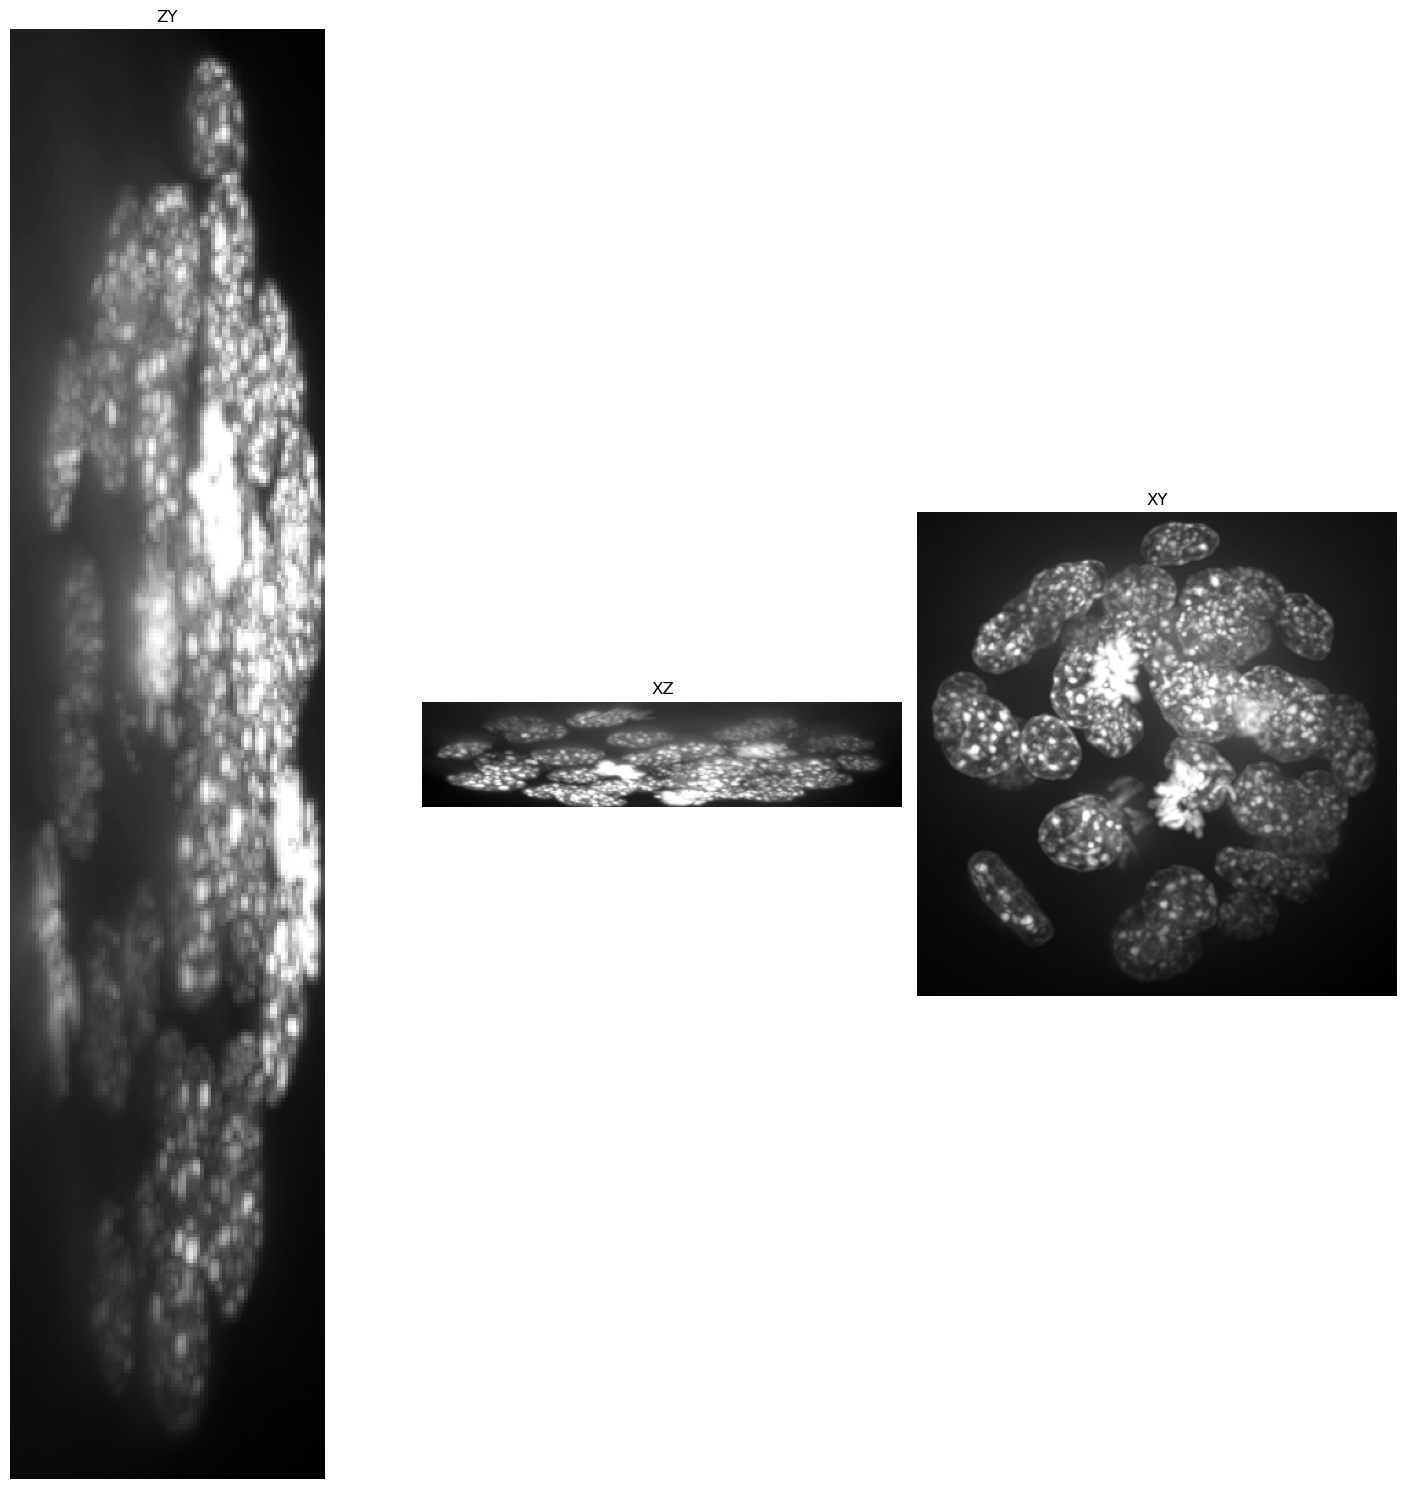

In [3]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(projection_x, cmap='prism' if labels else 'gray')
    axs[0].set_title("ZY")
    axs[1].imshow(projection_y, cmap='prism' if labels else 'gray')
    axs[1].set_title("XZ")
    axs[2].imshow(projection_z, cmap='prism' if labels else 'gray')
    axs[2].set_title("XY")
    for ax in axs:
        ax.axis('off')
    fig.tight_layout()
    plt.show()

show(image)

### Exercise 1: rescale the image to make it isotropic

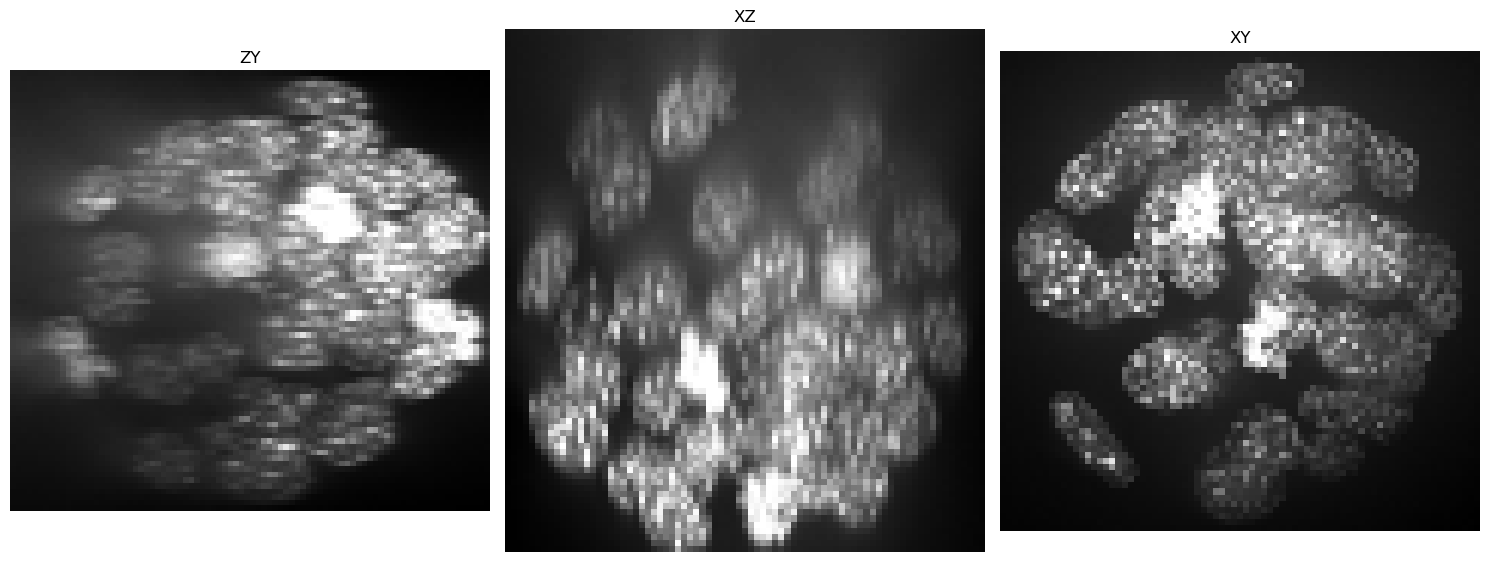

In [4]:
# TODO: use the function scale

rescaled = cle.create([int(image.shape[0] * voxel_size_z), int(image.shape[1] * voxel_size_y), int(image.shape[2] * voxel_size_x)])
cle.scale(image, rescaled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)

show(rescaled)

## Intensity correction

As we can see, intensity is decreasing in Z-direction (from slice to slice) and contrast as well. At least the intensity decay can be corrected. In [CLIJx](https://github.com/clij/clijx), this method is known as [equalize_mean_intensities_of_slices.](https://clij.github.io/clij2-docs/reference_equalizeMeanIntensitiesOfSlices)

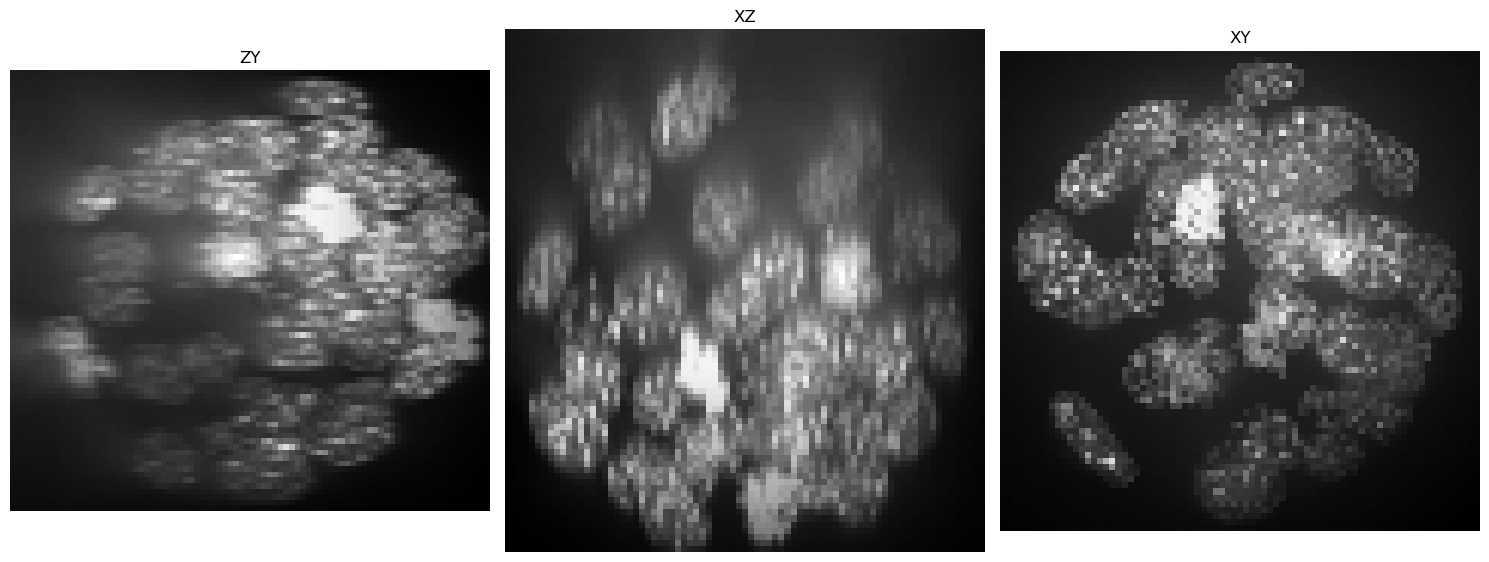

In [5]:
# Create a new empty image to store our results
equalized_intensities_stack = cle.create(rescaled)
a_slice = cle.create([rescaled.shape[1], rescaled.shape[2]])

num_slices = rescaled.shape[0]
mean_intensity_stack = cle.mean_of_all_pixels(rescaled)

for z in range(0, num_slices):
    # get a single slice out of the stack
    a_slice = rescaled[z, :, :]
    # measure the mean intensity of the slice
    mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
    # correct the intensity of the slice based on the mean intensity of the stack
    corrected_slice = a_slice * (mean_intensity_slice / mean_intensity_stack)
    # copy slice back in a stack
    cle.copy_slice(corrected_slice, equalized_intensities_stack, z)

show(equalized_intensities_stack)

## Segmentation

Now that our data is isotropic and its intensity comparable accross depth, we can start processing it and segment the cells

### Exercise 2: segment the cells

Hint: 
- You can improve signal contrast by using substracting the background approach
- clesperanto provide also high-level algorithm for segmentation (e.g. see at the top of this notebook)

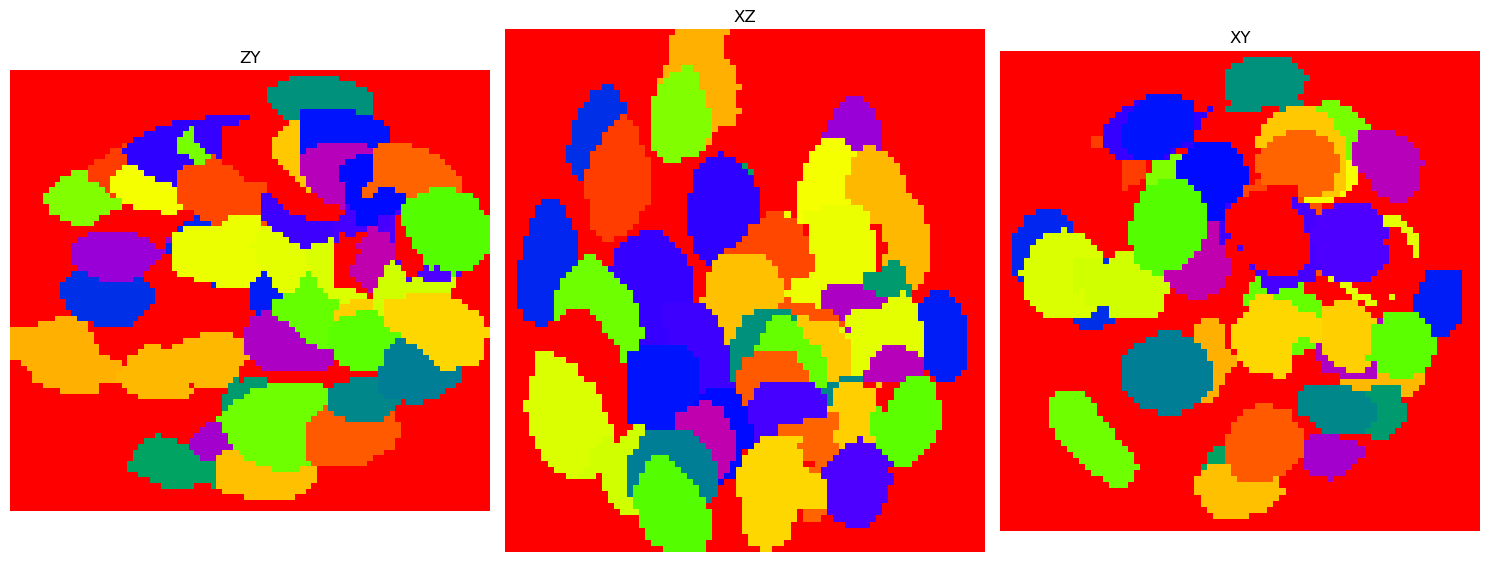

In [ ]:
# TODO: segments the cells in the image

background_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=5, radius_y=5, radius_z=5)
segmented = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=3, outline_sigma=1)

show(segmented, labels=True)

# Display the result in Napari

In [7]:
import napari
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(rescaled))
viewer.add_image(cle.pull(equalized_intensities_stack))
viewer.add_labels(cle.pull(segmented))

napari.run()